<a href="https://colab.research.google.com/github/Ajjme/Climate_system_modeling/blob/main/Emission_Nora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---- EN-ROADS Stock Simulation Results (Preview) ----
     Year  Net_Cumulative_Emissions_GtCO2  Annual_CO2_Emissions_GtCO2  \
0  2025.0                          1225.0                        35.0   
1  2026.0                          1260.0                        35.0   
2  2027.0                          1295.0                        35.0   
3  2028.0                          1330.0                        35.0   
4  2029.0                          1365.0                        35.0   

   ODS_Stockpiles_tons_CO2e  ODS_Annual_Leakage_tons_CO2e  \
0                1000000.00                      20000.00   
1                 880000.00                      20000.00   
2                 774400.00                      17600.00   
3                 681472.00                      15488.00   
4                 599695.36                      13629.44   

   ODS_Annual_Destruction_tons_CO2e  Post2100_C_Intensity_of_GDP  \
0                          100000.0                          0.0   
1   

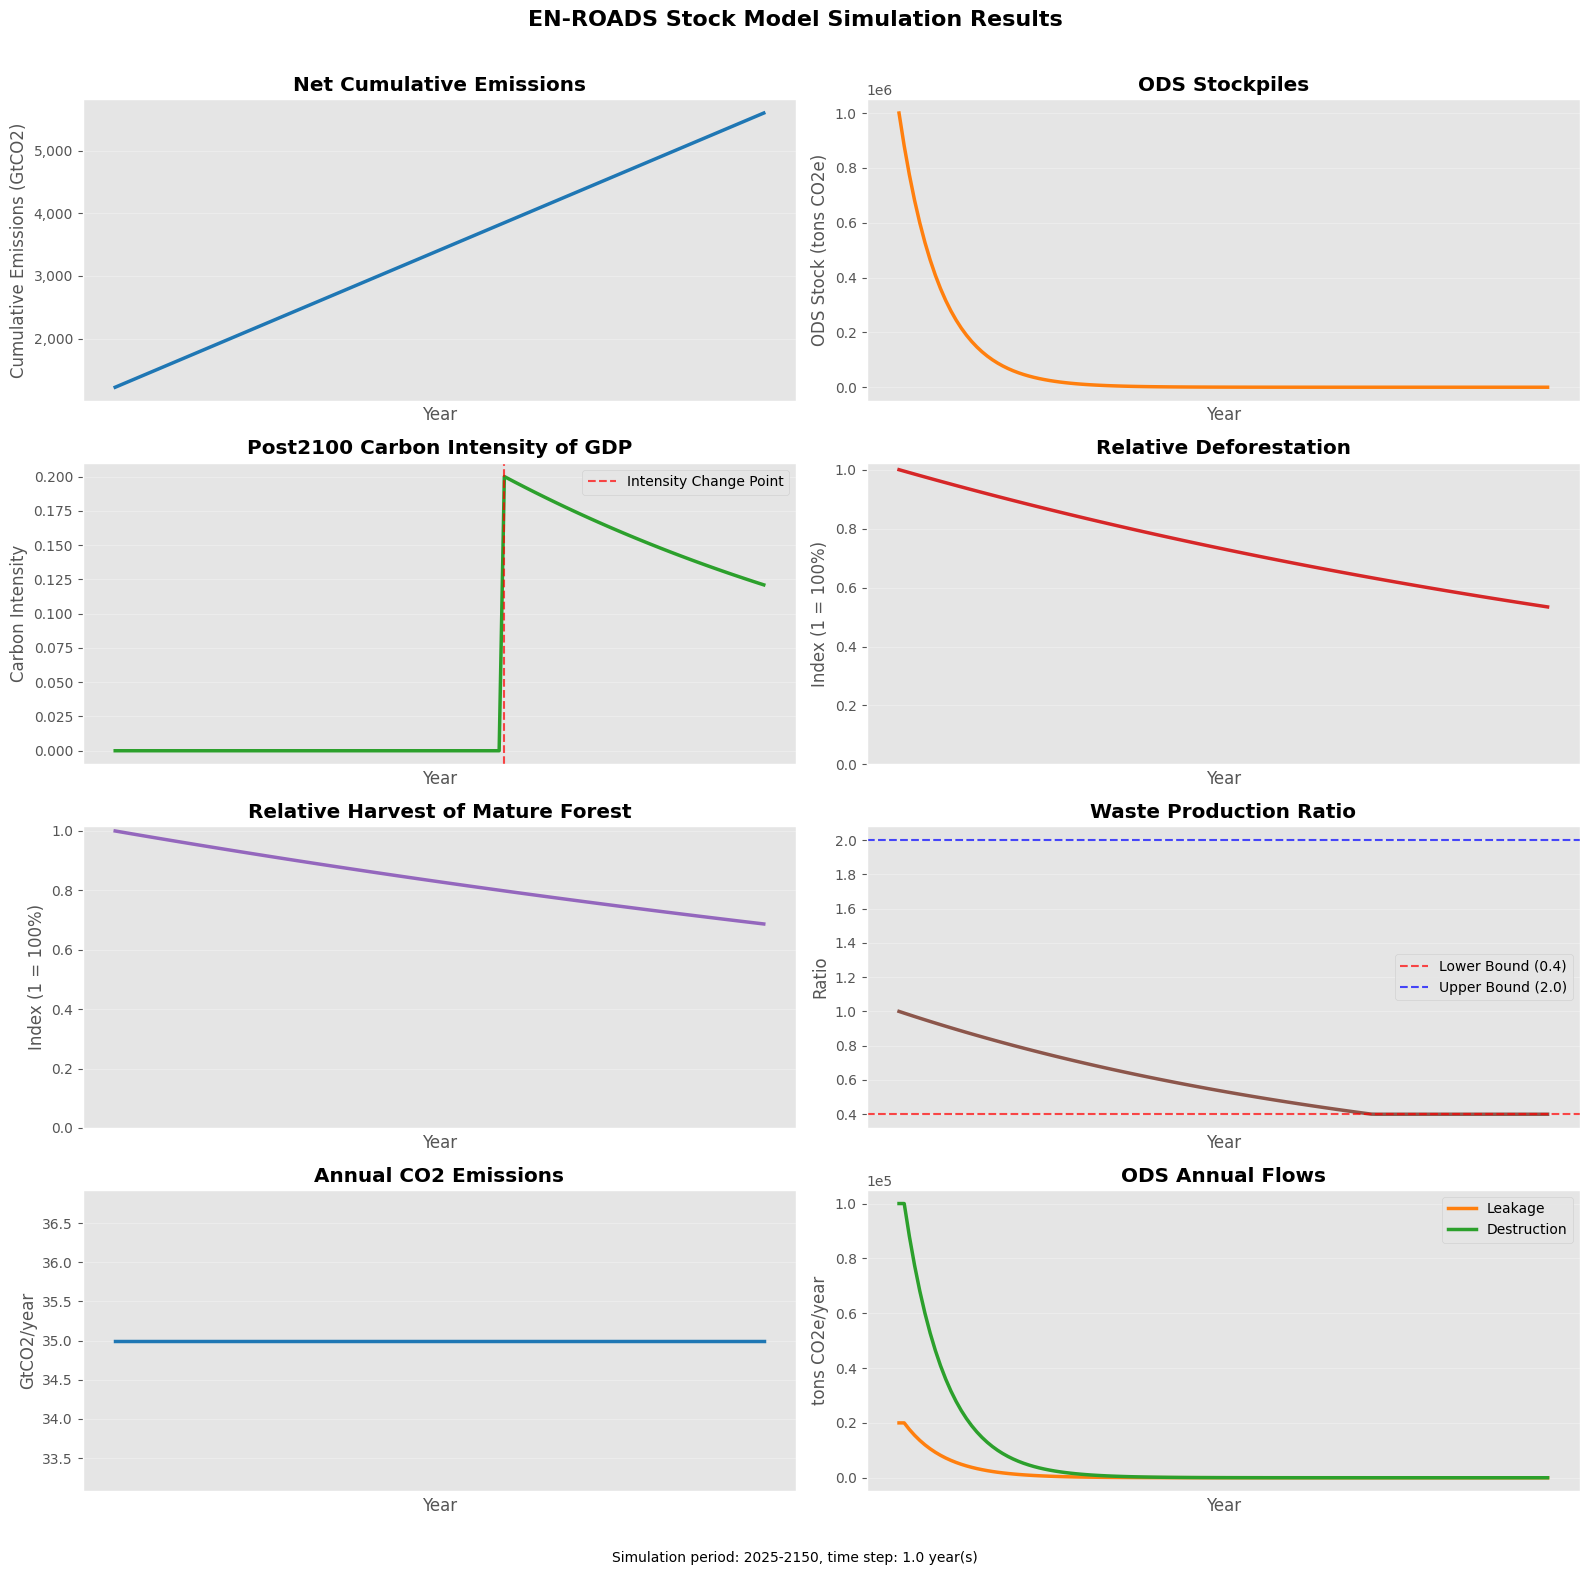

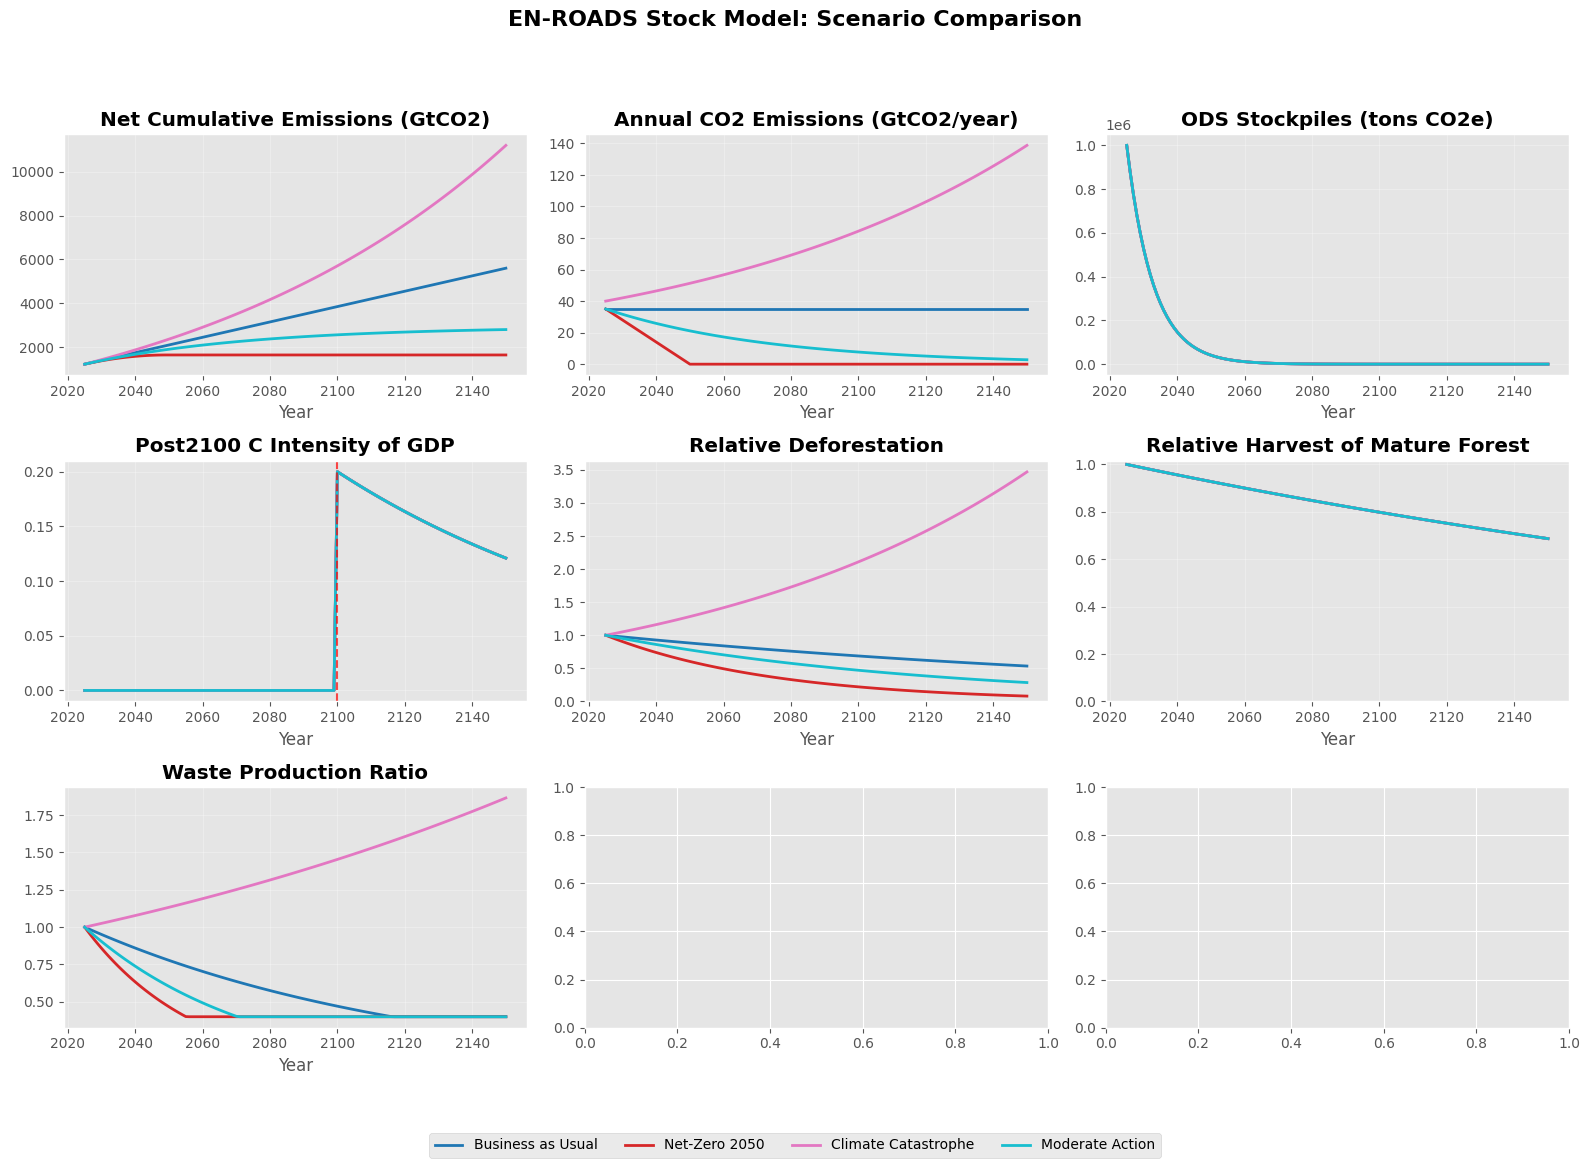

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


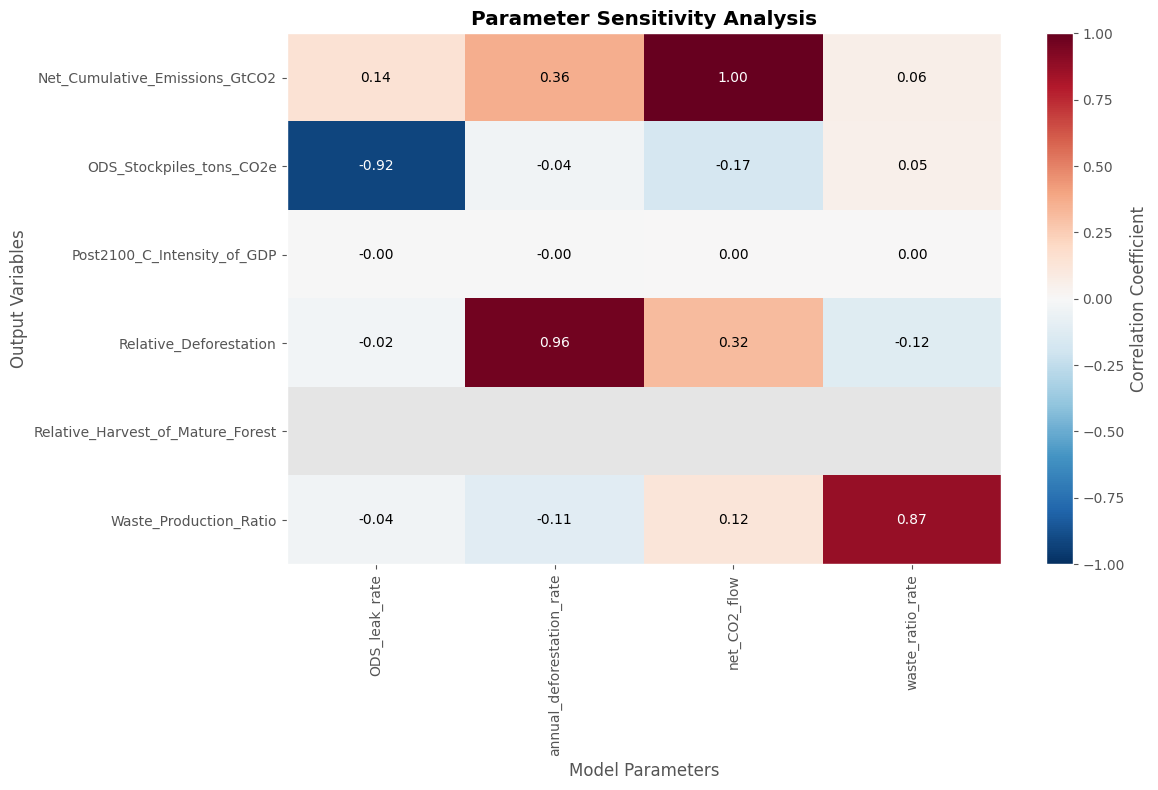

Model configuration saved to enroads_model_config.json
All scenario results exported to enroads_scenario_results.csv


In [5]:
# =============================================================================
# EN-ROADS Stock Models Implementation
#
# In this Emission module we implements six simplified stock integrations from EN‑ROADS
# climate simulation model with some improved documentation, structure, and features.
#
# Stocks implemented with corresponding EN-ROADS reference equations:
#   1. Net Cumulative Emissions: Cumulative sum of annual net CO2 emissions
#   2. ODS Stockpiles: Stock of ozone-depleting substances with leakage and destruction
#   3. Post2100 Carbon Intensity of GDP: Step function with decay after 2100
#   4. Relative Deforestation: Exponential decay or growth based on rates
#   5. Relative Harvest of Mature Forest: Exponential decay or growth based on rates
#   6. Waste Production Ratio: Bounded exponential decay toward minimum value
#
# References link is below:
#      https://docs.climateinteractive.org/projects/en-roads-reference-guide/
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
from typing import Dict, List, Tuple, Optional, Union, Callable, Any
import json
import warnings
from scipy import stats


class ENRoadsStockModel:
    """
    An implementation of key stock integrations from the EN-ROADS climate model.

    This class implements Euler integration for six important stocks from EN-ROADS,
    following the equations in the EN-ROADS technical reference:

    1. Net Cumulative Emissions:
       Stock(t) = Stock(t-1) + net_CO2_flow(t-1) * Δt

    2. ODS Stockpiles:
       Stock(t) = Stock(t-1) - (leakage_rate(t-1) + destruction_rate(t-1)) * Stock(t-1) * Δt

    3. Post2100 Carbon Intensity of GDP:
       If year == 2100:
           Stock(t) = Stock(t-1) + carbon_intensity_2100
       Else if year > 2100:
           Stock(t) = Stock(t-1) + Stock(t-1) * post2100_trend * Δt
       Else:
           Stock(t) = Stock(t-1)

    4. Relative Deforestation:
       Stock(t) = Stock(t-1) * (1 + deforestation_rate(t-1) * Δt)

    5. Relative Harvest of Mature Forest:
       Stock(t) = Stock(t-1) * (1 + harvest_rate(t-1) * Δt)

    6. Waste Production Ratio:
       Stock(t) = max(Stock(t-1) + Stock(t-1) * waste_ratio_rate(t-1) * Δt, waste_ratio_lower_bound)
    """

    def __init__(self,
                 start_year: int = 2025,
                 end_year: int = 2150,
                 time_step: float = 1.0,
                 custom_params: Optional[Dict] = None,
                 validate_params: bool = True):
        """
        Initialize the EN-ROADS stock model with simulation parameters.

        Args:
            start_year: First year of the simulation
            end_year: Last year of the simulation
            time_step: Integration time step in years
            custom_params: Optional dictionary of custom parameter values
            validate_params: Whether to validate parameters for physical consistency
        """
        # Input validation
        if end_year <= start_year:
            raise ValueError("end_year must be greater than start_year")
        if time_step <= 0:
            raise ValueError("time_step must be positive")

        # Simulation time parameters
        self.start_year = start_year
        self.end_year = end_year
        self.time_step = time_step
        self.years = np.arange(start_year, end_year + time_step, time_step)
        self.n_steps = len(self.years)
        self.validate_params = validate_params

        # Set up default parameters
        self._set_default_parameters()

        # Override with custom parameters if provided
        if custom_params:
            self._update_parameters(custom_params)

        # Initialize storage for results
        self.results = None
        self._initialize_stock_arrays()

        # Store scenario results
        self.scenario_results = {}

    def _set_default_parameters(self):
        """Set default parameters for the stock models based on EN-ROADS documentation."""
        # Initial stock values
        self.initial_values = {
            "net_cum_emissions": 1225.0,    # GtCO2; initial cumulative emissions as of start_year
            "ODS_stock": 1e6,               # tons CO2e; historic ODS stockpile
            "post2100_C_intensity": 0.0,    # baseline value (unitless)
            "relative_deforestation": 1.0,  # normalized index (1 = 100%)
            "relative_harvest": 1.0,        # normalized index (1 = 100%)
            "waste_ratio": 1.0              # baseline production ratio (unitless)
        }

        # Flow parameters with clearer units/descriptions based on EN-ROADS reference
        self.params = {
            # Net CO2 emissions parameters
            "net_CO2_flow": 35.0,           # GtCO2 per year (annual emissions)
            "net_CO2_growth_rate": 0.0,     # Annual growth rate of emissions (fraction)

            # ODS Stockpiles parameters
            "ODS_leak_rate": 0.02,          # Annual leakage rate (fraction of stock per year)
            "ODS_destruction_rate": 0.10,   # Annual destruction rate (fraction of stock per year)

            # Post2100 Carbon Intensity of GDP parameters
            "carbon_intensity_2100": 0.2,   # Pulse value at 2100 (unitless)
            "post2100_trend": -0.01,        # Annual decay rate after 2100 (fraction per year)

            # Relative Deforestation parameters
            "annual_deforestation_rate": -0.005,  # Annual rate of change (-0.5% per year)
            "min_deforestation": 0.0,       # Minimum allowed deforestation level

            # Relative Harvest of Mature Forest parameters
            "annual_harvest_rate": -0.003,  # Annual rate of change (-0.3% per year)
            "min_harvest": 0.0,             # Minimum allowed harvest level

            # Waste Production Ratio parameters
            "waste_ratio_rate": -0.01,      # Annual rate of change (-1% per year)
            "waste_ratio_lower_bound": 0.4, # Minimum allowed value
            "waste_ratio_upper_bound": 2.0  # Maximum allowed value
        }

        # Enable dynamic flow functions (defaulting to None)
        self.dynamic_flows = {
            "net_CO2_flow_func": None,
            "ODS_leak_rate_func": None,
            "ODS_destruction_rate_func": None,
            "deforestation_rate_func": None,
            "harvest_rate_func": None,
            "waste_ratio_rate_func": None
        }

    def _update_parameters(self, custom_params: Dict):
        """
        Update model parameters with custom values.

        Args:
            custom_params: Dictionary with parameter names and values
        """
        # Update initial values if provided
        if "initial_values" in custom_params:
            for key, value in custom_params["initial_values"].items():
                if key in self.initial_values:
                    self.initial_values[key] = value
                else:
                    raise ValueError(f"Unknown initial value key: {key}")

        # Update flow parameters if provided
        if "params" in custom_params:
            for key, value in custom_params["params"].items():
                if key in self.params:
                    self.params[key] = value
                else:
                    raise ValueError(f"Unknown parameter key: {key}")

        # Update dynamic flow functions if provided
        if "dynamic_flows" in custom_params:
            for key, func in custom_params["dynamic_flows"].items():
                if key in self.dynamic_flows:
                    # Verify callable
                    if func is not None and not callable(func):
                        raise TypeError(f"Dynamic flow {key} must be a callable function or None")
                    self.dynamic_flows[key] = func
                else:
                    raise ValueError(f"Unknown dynamic flow key: {key}")

        # Validate parameters if enabled
        if self.validate_params:
            self._validate_parameters()

    def _validate_parameters(self):
        """
        Validate parameter values for physical consistency.

        Raises:
            ValueError: If any parameter violates physical constraints
        """
        # Check initial values
        if self.initial_values["net_cum_emissions"] < 0:
            raise ValueError("Initial net cumulative emissions cannot be negative")
        if self.initial_values["ODS_stock"] < 0:
            raise ValueError("Initial ODS stock cannot be negative")
        if self.initial_values["relative_deforestation"] < 0:
            raise ValueError("Initial relative deforestation cannot be negative")
        if self.initial_values["relative_harvest"] < 0:
            raise ValueError("Initial relative harvest cannot be negative")
        if self.initial_values["waste_ratio"] < self.params["waste_ratio_lower_bound"]:
            raise ValueError("Initial waste ratio cannot be below the lower bound")
        if self.initial_values["waste_ratio"] > self.params["waste_ratio_upper_bound"]:
            raise ValueError("Initial waste ratio cannot be above the upper bound")

        # Check rate parameters
        if not (0 <= self.params["ODS_leak_rate"] <= 1):
            warnings.warn("ODS leak rate should be between 0 and 1")
        if not (0 <= self.params["ODS_destruction_rate"] <= 1):
            warnings.warn("ODS destruction rate should be between 0 and 1")

        # Check bounds
        if self.params["waste_ratio_lower_bound"] < 0:
            raise ValueError("Waste ratio lower bound cannot be negative")
        if self.params["waste_ratio_lower_bound"] >= self.params["waste_ratio_upper_bound"]:
            raise ValueError("Waste ratio lower bound must be less than upper bound")

    def _initialize_stock_arrays(self):
        """Initialize arrays for storing stock values during simulation."""
        # Pre-allocate arrays for each stock
        self.net_cum_emissions = np.zeros(self.n_steps, dtype=float)
        self.ODS_stock = np.zeros(self.n_steps, dtype=float)
        self.post2100_C_intensity = np.zeros(self.n_steps, dtype=float)
        self.relative_deforestation = np.zeros(self.n_steps, dtype=float)
        self.relative_harvest = np.zeros(self.n_steps, dtype=float)
        self.waste_ratio = np.zeros(self.n_steps, dtype=float)

        # Set initial conditions
        self.net_cum_emissions[0] = self.initial_values["net_cum_emissions"]
        self.ODS_stock[0] = self.initial_values["ODS_stock"]
        self.post2100_C_intensity[0] = self.initial_values["post2100_C_intensity"]
        self.relative_deforestation[0] = self.initial_values["relative_deforestation"]
        self.relative_harvest[0] = self.initial_values["relative_harvest"]
        self.waste_ratio[0] = self.initial_values["waste_ratio"]

        # Also track flows for analysis
        self.co2_flow_history = np.zeros(self.n_steps, dtype=float)
        self.ods_leakage_history = np.zeros(self.n_steps, dtype=float)
        self.ods_destruction_history = np.zeros(self.n_steps, dtype=float)

    def _get_flow_rate(self, flow_key: str, t_idx: int, current_value: float) -> float:
        """
        Get a flow rate, either from a dynamic function or static parameter.

        Args:
            flow_key: Key name of the flow parameter
            t_idx: Current time index in the simulation
            current_value: Current stock value

        Returns:
            Flow rate value
        """
        # Check if there's a dynamic function for this flow
        func_key = f"{flow_key}_func"
        if func_key in self.dynamic_flows and self.dynamic_flows[func_key] is not None:
            # Call the dynamic function with current year, time index, and stock value
            return self.dynamic_flows[func_key](
                year=self.years[t_idx],
                t_idx=t_idx,
                current_value=current_value
            )
        else:
            # Return the static parameter value
            return self.params[flow_key]

    def _update_net_cum_emissions(self, t_idx: int) -> None:
        """
        Update Net Cumulative Emissions stock.

        Equation: Stock(t) = Stock(t-1) + net_CO2_flow(t-1) * Δt

        Args:
            t_idx: Current time index
        """
        # Get current CO2 flow (static or dynamic)
        co2_flow = self._get_flow_rate("net_CO2_flow", t_idx, self.net_cum_emissions[t_idx-1])

        # Apply growth rate if no dynamic function is specified
        if self.dynamic_flows["net_CO2_flow_func"] is None and self.params["net_CO2_growth_rate"] != 0:
            co2_flow *= (1 + self.params["net_CO2_growth_rate"]) ** (t_idx * self.time_step)

        # Calculate new cumulative emissions
        self.co2_flow_history[t_idx] = co2_flow
        self.net_cum_emissions[t_idx] = self.net_cum_emissions[t_idx-1] + co2_flow * self.time_step

    def _update_ods_stockpiles(self, t_idx: int) -> None:
        """
        Update ODS Stockpiles stock.

        Equation: Stock(t) = Stock(t-1) - (leakage_rate + destruction_rate) * Stock(t-1) * Δt

        Args:
            t_idx: Current time index
        """
        # Get current leak and destruction rates (static or dynamic)
        ods_leak_rate = self._get_flow_rate("ODS_leak_rate", t_idx, self.ODS_stock[t_idx-1])
        ods_destruction_rate = self._get_flow_rate("ODS_destruction_rate", t_idx, self.ODS_stock[t_idx-1])

        # Calculate leakage and destruction flows
        ods_leaks = ods_leak_rate * self.ODS_stock[t_idx-1]
        ods_destruction = ods_destruction_rate * self.ODS_stock[t_idx-1]

        # Record flow histories
        self.ods_leakage_history[t_idx] = ods_leaks
        self.ods_destruction_history[t_idx] = ods_destruction

        # Update stock with Euler integration
        self.ODS_stock[t_idx] = max(0, self.ODS_stock[t_idx-1] -
                                   (ods_leaks + ods_destruction) * self.time_step)

    def _update_post2100_c_intensity(self, t_idx: int) -> None:
        """
        Update Post2100 Carbon Intensity of GDP stock.

        Equations:
        - If year < 2100: Stock(t) = Stock(t-1)
        - If year = 2100: Stock(t) = Stock(t-1) + carbon_intensity_2100
        - If year > 2100: Stock(t) = Stock(t-1) + Stock(t-1) * post2100_trend * Δt

        Args:
            t_idx: Current time index
        """
        current_year = self.years[t_idx]

        # Piecewise function based on time
        if current_year < 2100:
            # Before 2100: No change
            self.post2100_C_intensity[t_idx] = self.post2100_C_intensity[t_idx-1]
        else:
            if current_year == 2100:
                # At 2100: Step change
                self.post2100_C_intensity[t_idx] = (self.post2100_C_intensity[t_idx-1] +
                                                   self.params["carbon_intensity_2100"])
            else:
                # After 2100: Exponential decay
                delta_intensity = self.post2100_C_intensity[t_idx-1] * self.params["post2100_trend"]
                self.post2100_C_intensity[t_idx] = (self.post2100_C_intensity[t_idx-1] +
                                                  delta_intensity * self.time_step)

    def _update_relative_deforestation(self, t_idx: int) -> None:
        """
        Update Relative Deforestation stock.

        Equation: Stock(t) = max(Stock(t-1) * (1 + deforestation_rate * Δt), min_deforestation)

        Args:
            t_idx: Current time index
        """
        # Get deforestation rate (static or dynamic)
        deforestation_rate = self._get_flow_rate("annual_deforestation_rate", t_idx,
                                               self.relative_deforestation[t_idx-1])

        # Update with exponential growth/decay and enforce minimum
        self.relative_deforestation[t_idx] = self.relative_deforestation[t_idx-1] * (
            1 + deforestation_rate * self.time_step)

        # Apply minimum bound
        self.relative_deforestation[t_idx] = max(
            self.params["min_deforestation"],
            self.relative_deforestation[t_idx]
        )

    def _update_relative_harvest(self, t_idx: int) -> None:
        """
        Update Relative Harvest of Mature Forest stock.

        Equation: Stock(t) = max(Stock(t-1) * (1 + harvest_rate * Δt), min_harvest)

        Args:
            t_idx: Current time index
        """
        # Get harvest rate (static or dynamic)
        harvest_rate = self._get_flow_rate("annual_harvest_rate", t_idx,
                                         self.relative_harvest[t_idx-1])

        # Update with exponential growth/decay and enforce minimum
        self.relative_harvest[t_idx] = self.relative_harvest[t_idx-1] * (
            1 + harvest_rate * self.time_step)

        # Apply minimum bound
        self.relative_harvest[t_idx] = max(
            self.params["min_harvest"],
            self.relative_harvest[t_idx]
        )

    def _update_waste_production_ratio(self, t_idx: int) -> None:
        """
        Update Waste Production Ratio stock.

        Equation: Stock(t) = min(max(Stock(t-1) + Stock(t-1) * waste_ratio_rate * Δt,
                               waste_ratio_lower_bound), waste_ratio_upper_bound)

        Args:
            t_idx: Current time index
        """
        # Get waste rate (static or dynamic)
        waste_rate = self._get_flow_rate("waste_ratio_rate", t_idx, self.waste_ratio[t_idx-1])

        # Calculate new waste ratio with bounds
        delta_waste = waste_rate * self.waste_ratio[t_idx-1] * self.time_step
        self.waste_ratio[t_idx] = self.waste_ratio[t_idx-1] + delta_waste

        # Apply bounds
        self.waste_ratio[t_idx] = min(
            max(self.params["waste_ratio_lower_bound"], self.waste_ratio[t_idx]),
            self.params["waste_ratio_upper_bound"]
        )

    def run_simulation(self) -> pd.DataFrame:
        """
        Run the stock simulation for all years in the timeframe.

        Returns:
            DataFrame containing simulation results for all stocks over time
        """
        # Reset arrays to initial conditions
        self._initialize_stock_arrays()

        # Record initial flows at t=0
        if self.dynamic_flows["net_CO2_flow_func"] is not None:
            self.co2_flow_history[0] = self.dynamic_flows["net_CO2_flow_func"](
                year=self.years[0], t_idx=0, current_value=self.net_cum_emissions[0]
            )
        else:
            self.co2_flow_history[0] = self.params["net_CO2_flow"]

        self.ods_leakage_history[0] = self.params["ODS_leak_rate"] * self.ODS_stock[0]
        self.ods_destruction_history[0] = self.params["ODS_destruction_rate"] * self.ODS_stock[0]

        # Main simulation loop - modularized for clarity
        for t in range(1, self.n_steps):
            # Update each stock using its specific method
            self._update_net_cum_emissions(t)
            self._update_ods_stockpiles(t)
            self._update_post2100_c_intensity(t)
            self._update_relative_deforestation(t)
            self._update_relative_harvest(t)
            self._update_waste_production_ratio(t)

        # Compile results into a DataFrame
        self.results = pd.DataFrame({
            'Year': self.years,
            'Net_Cumulative_Emissions_GtCO2': self.net_cum_emissions,
            'Annual_CO2_Emissions_GtCO2': self.co2_flow_history,
            'ODS_Stockpiles_tons_CO2e': self.ODS_stock,
            'ODS_Annual_Leakage_tons_CO2e': self.ods_leakage_history,
            'ODS_Annual_Destruction_tons_CO2e': self.ods_destruction_history,
            'Post2100_C_Intensity_of_GDP': self.post2100_C_intensity,
            'Relative_Deforestation': self.relative_deforestation,
            'Relative_Harvest_of_Mature_Forest': self.relative_harvest,
            'Waste_Production_Ratio': self.waste_ratio
        })

        return self.results

    def plot_results(self,
                     figsize: Tuple[int, int] = (16, 12),
                     style: str = 'ggplot',
                     save_path: Optional[str] = None,
                     show_flows: bool = True) -> None:
        """
        Plot the simulation results for all stocks.

        Args:
            figsize: Figure size as (width, height) tuple
            style: Matplotlib style to use
            save_path: Optional path to save the figure
            show_flows: Whether to include flow rates in the plots
        """
        if self.results is None:
            raise ValueError("You must run the simulation before plotting results.")

        # Set the plotting style
        plt.style.use(style)

        # Create figure with proper subplot arrangement
        n_plots = 8 if show_flows else 6  # Add flow plots if requested

        if n_plots <= 6:
            fig, axes = plt.subplots(3, 2, figsize=figsize)
            axes = axes.flatten()  # Flatten for easier indexing
        else:
            fig, axes = plt.subplots(4, 2, figsize=(figsize[0], figsize[1]*4/3))
            axes = axes.flatten()  # Flatten for easier indexing

        # Format y-axis with commas for thousands
        def format_with_commas(x, pos):
            return f'{x:,.0f}'

        # 1. Net Cumulative Emissions
        axes[0].plot(self.results['Year'], self.results['Net_Cumulative_Emissions_GtCO2'],
                    lw=2.5, color='#1f77b4')
        axes[0].set_xlabel('Year')
        axes[0].set_ylabel('Cumulative Emissions (GtCO2)')
        axes[0].set_title('Net Cumulative Emissions', fontweight='bold')
        axes[0].grid(True, alpha=0.3)
        # Format y-axis with comma separators
        axes[0].yaxis.set_major_formatter(FuncFormatter(format_with_commas))

        # 2. ODS Stockpiles
        axes[1].plot(self.results['Year'], self.results['ODS_Stockpiles_tons_CO2e'],
                    lw=2.5, color='#ff7f0e')
        axes[1].set_xlabel('Year')
        axes[1].set_ylabel('ODS Stock (tons CO2e)')
        axes[1].set_title('ODS Stockpiles', fontweight='bold')
        axes[1].grid(True, alpha=0.3)
        # Format with scientific notation
        axes[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

        # 3. Post2100 C Intensity of GDP
        axes[2].plot(self.results['Year'], self.results['Post2100_C_Intensity_of_GDP'],
                    lw=2.5, color='#2ca02c')
        axes[2].set_xlabel('Year')
        axes[2].set_ylabel('Carbon Intensity')
        axes[2].set_title('Post2100 Carbon Intensity of GDP', fontweight='bold')
        axes[2].grid(True, alpha=0.3)
        # Add vertical line at 2100
        axes[2].axvline(x=2100, color='red', linestyle='--', alpha=0.7,
                       label='Intensity Change Point')
        axes[2].legend()

        # 4. Relative Deforestation
        axes[3].plot(self.results['Year'], self.results['Relative_Deforestation'],
                    lw=2.5, color='#d62728')
        axes[3].set_xlabel('Year')
        axes[3].set_ylabel('Index (1 = 100%)')
        axes[3].set_title('Relative Deforestation', fontweight='bold')
        axes[3].grid(True, alpha=0.3)
        # Set y-axis limits
        axes[3].set_ylim(bottom=0)

        # 5. Relative Harvest of Mature Forest
        axes[4].plot(self.results['Year'], self.results['Relative_Harvest_of_Mature_Forest'],
                    lw=2.5, color='#9467bd')
        axes[4].set_xlabel('Year')
        axes[4].set_ylabel('Index (1 = 100%)')
        axes[4].set_title('Relative Harvest of Mature Forest', fontweight='bold')
        axes[4].grid(True, alpha=0.3)
        # Set y-axis limits
        axes[4].set_ylim(bottom=0)

        # 6. Waste Production Ratio
        axes[5].plot(self.results['Year'], self.results['Waste_Production_Ratio'],
                    lw=2.5, color='#8c564b')
        axes[5].set_xlabel('Year')
        axes[5].set_ylabel('Ratio')
        axes[5].set_title('Waste Production Ratio', fontweight='bold')
        axes[5].grid(True, alpha=0.3)
        # Add horizontal lines at bounds
        axes[5].axhline(y=self.params["waste_ratio_lower_bound"], color='red', linestyle='--',
                       alpha=0.7, label=f'Lower Bound ({self.params["waste_ratio_lower_bound"]})')
        axes[5].axhline(y=self.params["waste_ratio_upper_bound"], color='blue', linestyle='--',
                       alpha=0.7, label=f'Upper Bound ({self.params["waste_ratio_upper_bound"]})')
        axes[5].legend()

        # Add flow rate plots if requested
        if show_flows and n_plots > 6:
            # Annual CO2 Emissions
            axes[6].plot(self.results['Year'], self.results['Annual_CO2_Emissions_GtCO2'],
                        lw=2.5, color='#1f77b4')
            axes[6].set_xlabel('Year')
            axes[6].set_ylabel('GtCO2/year')
            axes[6].set_title('Annual CO2 Emissions', fontweight='bold')
            axes[6].grid(True, alpha=0.3)

            # ODS Flows (Leakage and Destruction)
            axes[7].plot(self.results['Year'], self.results['ODS_Annual_Leakage_tons_CO2e'],
                        lw=2.5, color='#ff7f0e', label='Leakage')
            axes[7].plot(self.results['Year'], self.results['ODS_Annual_Destruction_tons_CO2e'],
                        lw=2.5, color='#2ca02c', label='Destruction')
            axes[7].set_xlabel('Year')
            axes[7].set_ylabel('tons CO2e/year')
            axes[7].set_title('ODS Annual Flows', fontweight='bold')
            axes[7].grid(True, alpha=0.3)
            axes[7].legend()
            axes[7].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

            # Common formatting for all subplots
        for ax in axes:
            # Format the x-axis with less cluttered ticks
            ax.xaxis.set_major_locator(mdates.YearLocator(base=25))

        # Add super title and information
        fig.suptitle('EN-ROADS Stock Model Simulation Results', fontsize=16, fontweight='bold')
        plt.figtext(0.5, 0.01,
                   f"Simulation period: {self.start_year}-{self.end_year}, time step: {self.time_step} year(s)",
                   ha='center', fontsize=10)

        plt.tight_layout(rect=[0, 0.03, 1, 0.97])

        # Save figure if path is provided
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')

        plt.show()

    def run_scenario(self, scenario_name: str, scenario_params: Dict) -> pd.DataFrame:
        """
        Run a specific scenario by temporarily updating parameters.

        Args:
            scenario_name: Name of the scenario
            scenario_params: Dictionary with scenario-specific parameters

        Returns:
            DataFrame with scenario results
        """
        # Store original parameters
        original_params = self.params.copy()
        original_initial_values = self.initial_values.copy()
        original_dynamic_flows = self.dynamic_flows.copy()

        # Update parameters for this scenario
        self._update_parameters(scenario_params)

        # Run the simulation
        results = self.run_simulation()

        # Add scenario name column
        results['Scenario'] = scenario_name

        # Store in scenario results
        self.scenario_results[scenario_name] = results.copy()

        # Restore original parameters
        self.params = original_params
        self.initial_values = original_initial_values
        self.dynamic_flows = original_dynamic_flows

        return results

    def compare_scenarios(self,
                         scenarios: Dict[str, Dict],
                         stock_names: Optional[List[str]] = None,
                         figsize: Tuple[int, int] = (16, 12),
                         save_path: Optional[str] = None) -> pd.DataFrame:
        """
        Compare multiple scenarios for selected stocks.

        Args:
            scenarios: Dictionary mapping scenario names to parameter dictionaries
            stock_names: List of stock names to compare (defaults to all)
            figsize: Figure size
            save_path: Optional path to save the figure

        Returns:
            DataFrame containing combined results from all scenarios
        """
        # Default to all stock columns if not specified
        if stock_names is None:
            stock_names = [
                'Net_Cumulative_Emissions_GtCO2',
                'Annual_CO2_Emissions_GtCO2',
                'ODS_Stockpiles_tons_CO2e',
                'Post2100_C_Intensity_of_GDP',
                'Relative_Deforestation',
                'Relative_Harvest_of_Mature_Forest',
                'Waste_Production_Ratio'
            ]

        # Pretty names for plot titles
        pretty_names = {
            'Net_Cumulative_Emissions_GtCO2': 'Net Cumulative Emissions (GtCO2)',
            'Annual_CO2_Emissions_GtCO2': 'Annual CO2 Emissions (GtCO2/year)',
            'ODS_Stockpiles_tons_CO2e': 'ODS Stockpiles (tons CO2e)',
            'ODS_Annual_Leakage_tons_CO2e': 'ODS Annual Leakage (tons CO2e/year)',
            'ODS_Annual_Destruction_tons_CO2e': 'ODS Annual Destruction (tons CO2e/year)',
            'Post2100_C_Intensity_of_GDP': 'Post2100 C Intensity of GDP',
            'Relative_Deforestation': 'Relative Deforestation',
            'Relative_Harvest_of_Mature_Forest': 'Relative Harvest of Mature Forest',
            'Waste_Production_Ratio': 'Waste Production Ratio'
        }

        # Run all scenarios and collect results
        all_results = pd.DataFrame()
        for name, params in scenarios.items():
            scenario_results = self.run_scenario(name, params)
            all_results = pd.concat([all_results, scenario_results])

        # Set up the plots
        n_stocks = len(stock_names)
        n_cols = min(3, n_stocks)
        n_rows = (n_stocks + n_cols - 1) // n_cols  # Ceiling division

        plt.style.use('ggplot')
        fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)

        # Handle single row/col cases
        if n_stocks == 1:
            axes = np.array([axes])

        # Flatten for easier indexing if needed
        axes = np.array(axes).reshape(-1)[:n_stocks]

        # Color cycle for consistent coloring
        colors = plt.cm.tab10(np.linspace(0, 1, len(scenarios)))

        # Create one subplot for each stock
        for i, stock_name in enumerate(stock_names):
            ax = axes[i]

            # Plot each scenario
            for j, scenario in enumerate(scenarios.keys()):
                scenario_data = all_results[all_results['Scenario'] == scenario]
                ax.plot(scenario_data['Year'], scenario_data[stock_name],
                       lw=2, label=scenario, color=colors[j])

            # Formatting
            ax.set_xlabel('Year')
            ax.set_title(pretty_names.get(stock_name, stock_name), fontweight='bold')
            ax.grid(True, alpha=0.3)

            # Handle y-axis format for specific stocks
            if stock_name == 'ODS_Stockpiles_tons_CO2e':
                ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
            elif 'ODS_Annual' in stock_name:
                ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

            # Add vertical line at 2100 for the post-2100 carbon intensity
            if stock_name == 'Post2100_C_Intensity_of_GDP':
                ax.axvline(x=2100, color='red', linestyle='--', alpha=0.7,
                          label='2100 Transition')

            # Set minimum y to 0 for certain stocks
            if stock_name in ['Relative_Deforestation', 'Relative_Harvest_of_Mature_Forest']:
                ax.set_ylim(bottom=0)

        # Create a single legend for the entire figure
        handles, labels = axes[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05),
                 ncol=min(5, len(scenarios)), frameon=True)

        # Add super title
        fig.suptitle('EN-ROADS Stock Model: Scenario Comparison', fontsize=16, fontweight='bold')

        plt.tight_layout(rect=[0, 0.08, 1, 0.95])

        # Save figure if path is provided
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')

        plt.show()

        return all_results

    def export_results(self, filepath: str, format: str = 'csv') -> None:
        """
        Export simulation results to a file.

        Args:
            filepath: Path to save the results
            format: File format ('csv' or 'excel')
        """
        if self.results is None:
            raise ValueError("You must run the simulation before exporting results.")

        # Export based on format
        if format.lower() == 'csv':
            self.results.to_csv(filepath, index=False)
        elif format.lower() in ('excel', 'xlsx', 'xls'):
            self.results.to_excel(filepath, index=False)
        else:
            raise ValueError(f"Unsupported export format: {format}")

        print(f"Results exported to {filepath}")

    def export_scenario_results(self, filepath: str, format: str = 'csv') -> None:
        """
        Export all scenario results to a file.

        Args:
            filepath: Path to save the results
            format: File format ('csv' or 'excel')
        """
        if not self.scenario_results:
            raise ValueError("You must run at least one scenario before exporting.")

        # Combine all scenario results
        all_results = pd.concat(list(self.scenario_results.values()))

        # Export based on format
        if format.lower() == 'csv':
            all_results.to_csv(filepath, index=False)
        elif format.lower() in ('excel', 'xlsx', 'xls'):
            all_results.to_excel(filepath, index=False)
        else:
            raise ValueError(f"Unsupported export format: {format}")

        print(f"All scenario results exported to {filepath}")

    def save_model_config(self, filepath: str) -> None:
        """
        Save the current model configuration to a JSON file.

        Args:
            filepath: Path to save the configuration
        """
        # Create a configuration dictionary
        config = {
            "simulation": {
                "start_year": self.start_year,
                "end_year": self.end_year,
                "time_step": self.time_step
            },
            "initial_values": self.initial_values,
            "params": self.params
        }

        # Dynamic functions can't be serialized, so just note their presence
        dynamic_flow_info = {}
        for key, func in self.dynamic_flows.items():
            dynamic_flow_info[key] = func is not None

        config["dynamic_flows_present"] = dynamic_flow_info

        # Save to file
        with open(filepath, 'w') as f:
            json.dump(config, f, indent=2)

        print(f"Model configuration saved to {filepath}")

    @classmethod
    def load_model_config(cls, filepath: str) -> 'ENRoadsStockModel':
        """
        Create a model instance from a saved configuration file.

        Args:
            filepath: Path to the configuration file

        Returns:
            New ENRoadsStockModel instance with loaded configuration
        """
        # Load configuration from file
        with open(filepath, 'r') as f:
            config = json.load(f)

        # Create model with simulation parameters
        model = cls(
            start_year=config["simulation"]["start_year"],
            end_year=config["simulation"]["end_year"],
            time_step=config["simulation"]["time_step"],
            custom_params={
                "initial_values": config["initial_values"],
                "params": config["params"]
            }
        )

        print(f"Model configuration loaded from {filepath}")
        return model

    def perform_sensitivity_analysis(self,
                                    param_ranges: Dict[str, Tuple[float, float]],
                                    n_samples: int = 100,
                                    output_vars: Optional[List[str]] = None,
                                    year_filter: Optional[int] = None) -> Dict[str, Dict[str, float]]:
        """
        Perform sensitivity analysis on model parameters.

        Args:
            param_ranges: Dictionary mapping parameter names to (min, max) tuples
            n_samples: Number of random samples to generate for each parameter
            output_vars: List of output variables to analyze (column names in results)
            year_filter: If provided, analyze results only at this specific year

        Returns:
            Dictionary mapping output variables to dictionaries of parameter sensitivities
        """
        if output_vars is None:
            output_vars = [
                'Net_Cumulative_Emissions_GtCO2',
                'ODS_Stockpiles_tons_CO2e',
                'Post2100_C_Intensity_of_GDP',
                'Relative_Deforestation',
                'Relative_Harvest_of_Mature_Forest',
                'Waste_Production_Ratio'
            ]

        # Store original parameters
        original_params = self.params.copy()

        # Prepare storage for results
        param_names = list(param_ranges.keys())
        results_table = []

        # Generate parameter combinations using Latin Hypercube Sampling
        # for more efficient coverage of parameter space
        sampler = stats.qmc.LatinHypercube(len(param_ranges))
        samples = sampler.random(n_samples)

        # Scale samples to parameter ranges and run simulations
        for i in range(n_samples):
            # Create parameter set
            params_dict = {"params": {}}
            for j, param_name in enumerate(param_names):
                min_val, max_val = param_ranges[param_name]
                param_value = min_val + samples[i, j] * (max_val - min_val)
                params_dict["params"][param_name] = param_value

            # Run simulation with this parameter set
            self._update_parameters(params_dict)
            sim_results = self.run_simulation()

            # Extract results for the specific year if requested
            if year_filter is not None:
                if year_filter not in sim_results['Year'].values:
                    closest_year = min(sim_results['Year'], key=lambda x: abs(x - year_filter))
                    warnings.warn(f"Year {year_filter} not found, using closest year: {closest_year}")
                    year_filter = closest_year

                sim_results = sim_results[sim_results['Year'] == year_filter]

            # Add parameters and results to the table
            row = {param: params_dict["params"].get(param, original_params.get(param))
                  for param in param_names}

            # Add output values
            for var in output_vars:
                if year_filter is not None:
                    row[var] = sim_results[var].iloc[0]
                else:
                    # Use final value if no year filter
                    row[var] = sim_results[var].iloc[-1]

            results_table.append(row)

        # Restore original parameters
        self.params = original_params

        # Convert to DataFrame for analysis
        results_df = pd.DataFrame(results_table)

        # Calculate correlation coefficients
        sensitivity_results = {}
        for output_var in output_vars:
            correlations = {}
            for param in param_names:
                correlations[param] = np.corrcoef(results_df[param], results_df[output_var])[0, 1]
            sensitivity_results[output_var] = correlations

        return sensitivity_results

    def plot_sensitivity_analysis(self,
                                 sensitivity_results: Dict[str, Dict[str, float]],
                                 figsize: Tuple[int, int] = (12, 8),
                                 save_path: Optional[str] = None) -> None:
        """
        Plot sensitivity analysis results.

        Args:
            sensitivity_results: Output from perform_sensitivity_analysis method
            figsize: Figure size
            save_path: Optional path to save the figure
        """
        plt.figure(figsize=figsize)

        # Organize data for plotting
        output_vars = list(sensitivity_results.keys())
        all_params = set()
        for sensitivities in sensitivity_results.values():
            all_params.update(sensitivities.keys())
        all_params = list(all_params)

        # Create a DataFrame for easier plotting
        data = []
        for output_var in output_vars:
            for param in all_params:
                sensitivity = sensitivity_results[output_var].get(param, 0)
                data.append({
                    'Output Variable': output_var,
                    'Parameter': param,
                    'Correlation': sensitivity
                })

        df = pd.DataFrame(data)

        # Plot as heatmap
        pivot_df = df.pivot(index='Output Variable', columns='Parameter', values='Correlation')
        plt.imshow(pivot_df, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)

        # Add colorbar
        cbar = plt.colorbar(label='Correlation Coefficient')

        # Add labels
        plt.title('Parameter Sensitivity Analysis', fontweight='bold')
        plt.xlabel('Model Parameters')
        plt.ylabel('Output Variables')

        # Add grid lines
        plt.grid(False)

        # Format ticks
        plt.xticks(range(len(pivot_df.columns)), pivot_df.columns, rotation=90)
        plt.yticks(range(len(pivot_df.index)), pivot_df.index)

        # Add correlation values as text
        for i in range(len(pivot_df.index)):
            for j in range(len(pivot_df.columns)):
                value = pivot_df.iloc[i, j]
                if not np.isnan(value):
                    plt.text(j, i, f'{value:.2f}', ha='center', va='center',
                           color='white' if abs(value) > 0.5 else 'black')

        plt.tight_layout()

        # Save figure if path is provided
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')

        plt.show()


# Example usage with enhanced features
if __name__ == "__main__":
    # Create a model with default parameters
    model = ENRoadsStockModel(start_year=2025, end_year=2150)

    # Run the baseline simulation
    results = model.run_simulation()
    print("---- EN-ROADS Stock Simulation Results (Preview) ----")
    print(results.head())
    print("...")
    print(results.tail())

    # Plot the results with flow rates
    model.plot_results(style='ggplot', show_flows=True)

    # Define a set of climate policy scenarios
    scenarios = {
        "Business as Usual": {
            "params": {
                "net_CO2_flow": 35.0,  # Current emission level
                "annual_deforestation_rate": -0.005,  # Slow improvement
                "waste_ratio_rate": -0.01  # Slow waste reduction
            }
        },
        "Net-Zero 2050": {
            "params": {
                "net_CO2_growth_rate": -0.05,  # Declining emissions
                "annual_deforestation_rate": -0.02,  # Faster deforestation reduction
                "waste_ratio_rate": -0.03  # Faster waste reduction
            },
            # Example of a dynamic flow function - emissions decline to zero by 2050
            "dynamic_flows": {
                "net_CO2_flow_func": lambda year, t_idx, current_value:
                    max(0, 35.0 * (1 - (year - 2025) / (2050 - 2025))) if year <= 2050 else 0
            }
        },
        "Climate Catastrophe": {
            "params": {
                "net_CO2_flow": 40.0,  # Higher initial emissions
                "net_CO2_growth_rate": 0.01,  # Growing emissions
                "annual_deforestation_rate": 0.01,  # Increasing deforestation
                "waste_ratio_rate": 0.005  # Increasing waste
            }
        },
        "Moderate Action": {
            "params": {
                "net_CO2_flow": 35.0,  # Current level
                "net_CO2_growth_rate": -0.02,  # Modest reduction
                "annual_deforestation_rate": -0.01,  # Moderate improvement
                "waste_ratio_rate": -0.02  # Moderate waste reduction
            }
        }
    }

    # Compare scenarios for all stocks
    model.compare_scenarios(scenarios=scenarios)

    # Perform sensitivity analysis on selected parameters
    sensitivity_params = {
        "net_CO2_flow": (20.0, 50.0),
        "ODS_leak_rate": (0.01, 0.05),
        "annual_deforestation_rate": (-0.02, 0.01),
        "waste_ratio_rate": (-0.03, 0.01)
    }

    sensitivity_results = model.perform_sensitivity_analysis(
        param_ranges=sensitivity_params,
        n_samples=50,  # 50 simulations for quick demonstration
        year_filter=2100  # Analyze results at year 2100
    )

    # Plot sensitivity analysis results
    model.plot_sensitivity_analysis(sensitivity_results)

    # Save model configuration
    model.save_model_config("enroads_model_config.json")

    # Export results to CSV
    model.export_scenario_results("enroads_scenario_results.csv")